# Hyper-Personalized Email Templates with Cerebras

This cookbook demonstrates real-time personalized email generation using:
- **Cerebras LLM** for ultra-fast inference
- **Pydantic** for type-safe structured outputs
- **Jinja2** for HTML templating

We'll generate personalized marketing emails that adapt to each user's language, tone, and personality.

## 1. Define Pydantic Schemas

Pydantic schemas ensure the LLM returns structured, validated JSON. This is crucial for reliable template rendering.

In [1]:
from typing import List
from pydantic import BaseModel, Field


class UserProfile(BaseModel):
    """User profile loaded from CSV - defines personalization dimensions."""
    user_id: str
    name: str = Field(description="User's first name")
    preferred_color: str = Field(description="red, green, or white")
    preferred_language: str = Field(description="en, sp, or de")
    gender: str = Field(description="male or female")
    tone: str = Field(description="formal, casual, or friendly")
    personality: str = Field(description="introverted, extroverted, or balanced")
    background_mode: str = Field(description="bright or dark")


class EmailContent(BaseModel):
    """Structured output schema - the LLM must return exactly these fields."""
    greeting: str = Field(description="Personalized greeting using the user's name")
    banner_text: str = Field(description="Short promotional banner text")
    headline: str = Field(description="Main headline, attention-grabbing")
    subheadline: str = Field(description="Supporting subheadline")
    cta_text: str = Field(description="Call-to-action button text")
    product_section_title: str = Field(description="Title for product section")
    product_tagline: str = Field(description="Short tagline for the featured product")
    promo_message: str = Field(description="Promotional message at bottom")


print("✅ Pydantic schemas defined")

✅ Pydantic schemas defined


## 2. Initialize Cerebras Client

We load the API key from environment variables and import constants from our config file to keep the notebook clean.

In [2]:
import os
from dotenv import load_dotenv
from cerebras.cloud.sdk import Cerebras

# Import all constants from our config file
from constants import (
    MODEL, PRODUCT_NAMES, PRODUCT_IMAGES, LANGUAGE_MAP,
    COLOR_SCHEMES, PERSONALITY_GUIDANCE, TONE_GUIDANCE
)

load_dotenv()

client = Cerebras(api_key=os.environ.get("CEREBRAS_API_KEY"))

print(f"✅ Cerebras client initialized with model: {MODEL}")

✅ Cerebras client initialized with model: gpt-oss-120b


## 3. Content Generation Function

This function calls the Cerebras API with a structured output schema. The LLM is constrained to return valid JSON matching our `EmailContent` schema.

In [3]:
import json
import time


def generate_email_content(user: UserProfile) -> tuple[EmailContent, float, dict]:
    """Generate personalized email content using Cerebras.
    
    Returns: (content, elapsed_time, usage_stats)
    """
    language = LANGUAGE_MAP.get(user.preferred_language, "English")
    product_name = PRODUCT_NAMES.get(user.gender, PRODUCT_NAMES["male"])
    
    # Concise prompt to minimize tokens while providing clear instructions
    prompt = f"""Generate email content for Backcountry.com.

USER: {user.name} | {language} | {user.tone} | {user.personality}
PRODUCT: {product_name}
TONE: {TONE_GUIDANCE.get(user.tone, '')}
STYLE: {PERSONALITY_GUIDANCE.get(user.personality, '')}

Write ALL content in {language}. Keep each field concise (1-2 sentences max)."""

    # Generate JSON schema directly from Pydantic model
    schema = EmailContent.model_json_schema()
    
    start_time = time.perf_counter()
    
    response = client.chat.completions.create(
        model=MODEL,
        messages=[{"role": "user", "content": prompt}],
        response_format={
            "type": "json_schema",
            "json_schema": {
                "name": "email_content",
                "strict": True,
                "schema": schema
            }
        },
        max_completion_tokens=2048,
        temperature=0.7,
    )
    
    elapsed = time.perf_counter() - start_time
    
    # Parse response with error handling
    raw_content = response.choices[0].message.content
    if raw_content is None:
        raise ValueError(f"LLM returned None. Finish reason: {response.choices[0].finish_reason}")
    
    content_dict = json.loads(raw_content)
    content = EmailContent(**content_dict)
    
    usage = {
        "prompt_tokens": response.usage.prompt_tokens,
        "completion_tokens": response.usage.completion_tokens,
        "total_tokens": response.usage.total_tokens
    }
    
    return content, elapsed, usage


print("✅ Content generation function ready")

✅ Content generation function ready


## 4. Template Rendering Function

Jinja2 combines LLM-generated content with user-specific styling (colors, images) into the final HTML email.

In [4]:
from jinja2 import Template
import base64


def load_image_as_data_uri(path: str) -> str:
    """Convert image to data URI for inline HTML embedding."""
    with open(path, "rb") as f:
        data = base64.b64encode(f.read()).decode()
    ext = path.split(".")[-1]
    return f"data:image/{ext};base64,{data}"


def render_email(user: UserProfile, content: EmailContent) -> str:
    """Render HTML email by combining content with user-specific styling."""
    with open("templates/email_template.html", "r") as f:
        template = Template(f.read())
    
    # Get color scheme based on user preferences
    colors = COLOR_SCHEMES.get(
        (user.preferred_color, user.background_mode),
        COLOR_SCHEMES[("white", "bright")]
    )
    
    # Get product image
    gender = user.gender if user.gender in PRODUCT_IMAGES else "male"
    color = user.preferred_color if user.preferred_color in PRODUCT_IMAGES[gender] else "white"
    product_image = load_image_as_data_uri(PRODUCT_IMAGES[gender][color])
    product_name = PRODUCT_NAMES.get(user.gender, PRODUCT_NAMES["male"])
    
    return template.render(
        greeting=content.greeting,
        banner_text=content.banner_text,
        headline=content.headline,
        subheadline=content.subheadline,
        cta_text=content.cta_text,
        product_section_title=content.product_section_title,
        product_name=product_name,
        product_tagline=content.product_tagline,
        promo_message=content.promo_message,
        product_image=product_image,
        **colors
    )


print("✅ Template rendering function ready")

✅ Template rendering function ready


## 5. Load User Data

User profiles are loaded from CSV. Each user has unique preferences that drive personalization.

In [5]:
import pandas as pd


def load_users(csv_path: str = "data/users.csv") -> List[UserProfile]:
    """Load user profiles from CSV into Pydantic models."""
    df = pd.read_csv(csv_path)
    return [UserProfile(**row.to_dict()) for _, row in df.iterrows()]


users = load_users()
print(f"✅ Loaded {len(users)} user profiles")
for u in users:
    print(f"   {u.name}: {u.preferred_language} | {u.preferred_color} | {u.tone} | {u.personality}")

✅ Loaded 6 user profiles
   Alex: en | red | casual | extroverted
   Maria: sp | green | friendly | balanced
   Klaus: de | white | formal | introverted
   Emma: en | red | casual | extroverted
   Jordan: en | green | friendly | balanced
   Sofia: sp | white | formal | introverted


## 6. Generate & Display Helper

This helper orchestrates the full pipeline: generate content → render template → display inline.

In [6]:
from IPython.display import HTML, display


def generate_and_display(user: UserProfile):
    """Full pipeline: generate content, render template, display email."""
    print(f"\n{'='*60}")
    print(f"🎯 {user.name} | {LANGUAGE_MAP.get(user.preferred_language)} | {user.tone} | {user.personality}")
    print(f"{'='*60}")
    
    content, elapsed, usage = generate_email_content(user)
    
    print(f"⚡ Generated in {elapsed:.2f}s | {usage['total_tokens']} tokens")
    print(f"📝 Greeting: {content.greeting}")
    print(f"📝 Headline: {content.headline}")
    
    html = render_email(user, content)
    display(HTML(html))
    
    return content, elapsed, usage

## 7. Generate Personalized Emails

Let's generate emails for users with different language, tone, and personality combinations.


🎯 Alex | English | casual | extroverted
⚡ Generated in 0.39s | 815 tokens
📝 Greeting: Hey Alex,
📝 Headline: Meet the Fitz Roy Icon Responsibili‑Tee!


Gear up for adventure with Patagonia's latest!
BACKCOUNTRY
"Hey Alex, Meet the Fitz Roy Icon Responsibili‑Tee! Sustainable style that’s as bold as your trails. Grab Yours Now!"
Featured Product
"Patagonia Fitz Roy Icon Responsibili-Tee - Men's Eco‑friendly, ultra‑comfortable, and ready for any summit!"
Shop today and get free shipping on orders over $50!
"© 2024 Backcountry.com. All rights reserved. 2607 South 3200 West, Suite A, Salt Lake City, UT 84119"

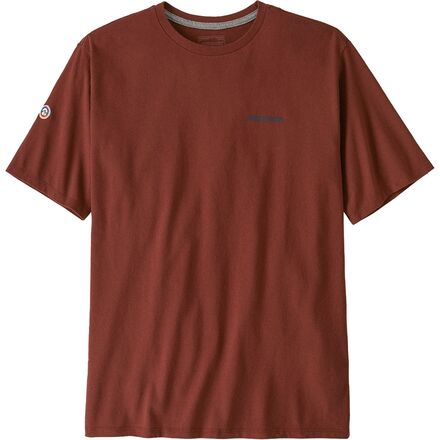

In [7]:
# English, casual, extroverted user
content1, time1, usage1 = generate_and_display(users[0])


🎯 Maria | Spanish | friendly | balanced
⚡ Generated in 1.92s | 832 tokens
📝 Greeting: ¡Hola María! Esperamos que estés teniendo un gran día.
📝 Headline: Descubre la nueva Patagonia Classic Microdini para mujer.


Explora la montaña con estilo y comodidad.
BACKCOUNTRY
"¡Hola María! Esperamos que estés teniendo un gran día. Descubre la nueva Patagonia Classic Microdini para mujer. Ligera, resistente y perfecta para cualquier aventura al aire libre. ¡Compra ahora y siente la diferencia!"
Producto destacado
Patagonia Classic Microdini Jacket - Women's Calidez y rendimiento en un diseño clásico.
Aprovecha envío gratis y devoluciones sin costo en tu primera compra.
"© 2024 Backcountry.com. All rights reserved. 2607 South 3200 West, Suite A, Salt Lake City, UT 84119"

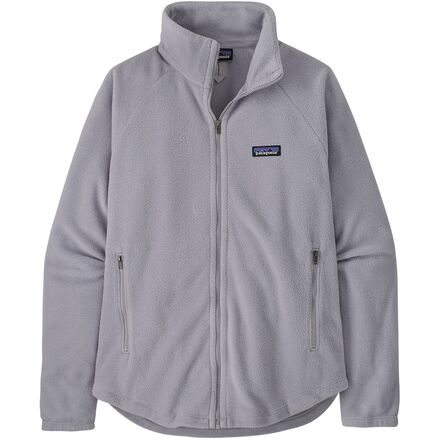

In [8]:
# Spanish, friendly, balanced user
content2, time2, usage2 = generate_and_display(users[1])


🎯 Klaus | German | formal | introverted
⚡ Generated in 0.37s | 775 tokens
📝 Greeting: Sehr geehrter Herr Klaus,
📝 Headline: Patagonia Fitz Roy Icon Responsibili‑Tee – Ihr Begleiter für verantwortungsbewusste Abenteuer.


Entdecken Sie nachhaltige Eleganz für anspruchsvolle Outdoor‑Erlebnisse.
BACKCOUNTRY
"Sehr geehrter Herr Klaus, Patagonia Fitz Roy Icon Responsibili‑Tee – Ihr Begleiter für verantwortungsbewusste Abenteuer. Ein hochwertiges Herren‑T-Shirt, das Stil, Komfort und Umweltbewusstsein vereint. Jetzt ansehen"
Produktdetails
"Patagonia Fitz Roy Icon Responsibili-Tee - Men's Zeitlose Qualität, die die Natur respektiert."
Profitieren Sie von kostenlosem Versand bei Ihrer ersten Bestellung.
"© 2024 Backcountry.com. All rights reserved. 2607 South 3200 West, Suite A, Salt Lake City, UT 84119"

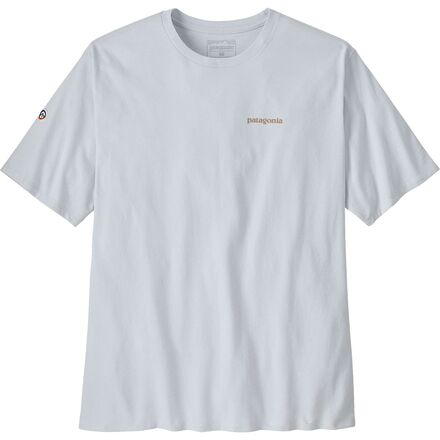

In [9]:
# German, formal, introverted user
content3, time3, usage3 = generate_and_display(users[2])

## 8. Performance Summary

Cerebras enables real-time personalization at scale. Let's benchmark all users.

In [10]:
print("\n" + "="*60)
print("⚡ CEREBRAS PERFORMANCE SUMMARY")
print("="*60)

times, tokens = [], 0
for i, user in enumerate(users):
    content, elapsed, usage = generate_email_content(user)
    times.append(elapsed)
    tokens += usage['total_tokens']
    lang = LANGUAGE_MAP.get(user.preferred_language, "en")[:2]
    print(f"User {i+1}: {lang} | {user.tone} | {user.personality} → {elapsed:.2f}s")

print(f"\n📊 Average: {sum(times)/len(times):.2f}s per email")
print(f"📊 Total: {sum(times):.2f}s for {len(users)} emails")
print(f"📊 Tokens: {tokens} total ({tokens//len(users)} avg)")
print(f"\n🚀 Real-time personalization at scale!")


⚡ CEREBRAS PERFORMANCE SUMMARY
User 1: En | casual | extroverted → 0.31s
User 2: Sp | friendly | balanced → 0.80s
User 3: Ge | formal | introverted → 0.46s
User 4: En | casual | extroverted → 0.30s
User 5: En | friendly | balanced → 0.81s
User 6: Sp | formal | introverted → 0.44s

📊 Average: 0.52s per email
📊 Total: 3.13s for 6 emails
📊 Tokens: 5241 total (873 avg)

🚀 Real-time personalization at scale!


## Conclusion

This cookbook demonstrated:
- **Structured Outputs**: Pydantic + JSON schema for reliable LLM responses
- **Template Separation**: LLM generates text, template handles layout/styling
- **Multi-dimensional Personalization**: Language, tone, personality, colors, products
- **Speed**: Cerebras enables real-time generation for production use cases